# Region-based CNNs

## Table of Content

### 1.0 RCNN
### 2.0 Fast RCNN 
### 3.0 Faster RCNN （TO DO）

### Object detection contains two main steps:
* Locate bounding boxes containing objects, where each box contain only one object 
* Classify object inside each bounding boxe and assign label to it 

### 1.0 [RCNN](https://arxiv.org/pdf/1311.2524.pdf) (2013)

RCNN was a pioneering approach that applies deep models to object detection, which was introduced by Ross Girshick et al. It is the first CNN that dramatically increases the performance of object detection, with 58.5 mAP on VOC-2007 image dataset.

![](./img/rcnn.png)

### Process

- **1.0** Select multiple high-quality proposed regions from the input image using *SELECTIVE SEARCH* algorithm. These regions are selected with different scales and different shapes. Then label each region class and its bounding box coordinates.
- **2.0** A well pretrained CNN (usually VGG or Resnet) is used without the last layer(output layer orclassification layer). It transforms regions input the same input dimensions and performs forward computation to extracgt features from the regions
- **3.0** The output features and labels of each proposed region are combined into 1D vector (as an instance) to train multiple support vectore machines for object classification. It means that for each class, it trains a SVM classifier.
- **4.0** The output features and labels of each proposed regions are combined intwo 1D vector (as an instance) to train a linear regression model for bounding box prediction.


### Key points

- It is the first paper that introduce regioned proposed method to detect multiple objects in an image.
- It proposes about ~2k regions from each image, which leads to massive forward computation and low efficiency (large needs for memory, slow computation).
- It randomly sample some positive examples (regions with object present) and negative examples (regions wihtout object present) during training.
- It takes about 13s to predict an image on GPU and 53s on CPU (slow prediction).
- It trans models (CNN. SVMs and regressor) separately （multi-stage training also needs more memory). There is no end to end training.

---

### 2.0 [Fast RCNN](https://arxiv.org/pdf/1504.08083.pdf) (2015)

The main problem with RCNN approach is:
- ~2k proposed regions requires massive forward computation. Moreover, these regions highly overlap resulting in a high volume of repetitive computations.

In the followup work by Ross Girshick, he proposed a method called Fast R-CNN that significantly speed up object detection. It results 70.0  mAP on VOC-2007+12 dataset.

![](./img/frcnn.png)


### Process

- **1.0** Instead of forward computing ~2k feature maps in RCNN, a Fast RCNN generate only one feature map from the entire image as input. 
- **2.0** Selective search generates N proposals, thier different shapes indicate regions of interests (RoIs) of different shapes on the feature map. In order to keep the same shapes extracted from these RoIs, an RoI pooling layer is introduced to extracts a fixed-length feature vector, which is finally passed to subsequent FC layers.
- **3.0** The shape of the FC layer output is transformed to N x (q+1) for object classification, wehere q is the number of classes and 1 indicates the background.
- **4.0** The shape of the FC layer output is transformed to N x 4 for bounding boxes prediction. 

### Key Points

- The architecture is trained end-to-end with a multi-task loss.
- Fast RCNN takes the entire image as input.
- It needs less because it directly outputs feature maps to FC layers.
- During training, it actually randomly sample balanced positve and negative examples. (in paper, it trains 128 boxes each iteration)
- Fast RCNN uses L1 loss for bounding box prediction as opposed to L2 loss in R-CNN which is more sensitive to outliers
- the present of RoI pooling layer allows us to abandon corp and wrap.

### 3.0 Faster RCNN

Faster RCNN was introduced in 2015 but it is still one of the most popular objection detection for most of the researchers. It provides higher accuracy (73.2 mAP on VOC07+12) and faster computation 


1. We use a 3 × 3 convolutional layer with a padding of 1 to transform the CNN output and set the number of output channels to c. This way, each element in the feature map the CNN extracts from the image is a new feature with a length of c.
2. We use each element in the feature map as a center to generate multiple anchor boxes of different sizes and aspect ratios and then label them.
3. We use the features of the elements of length c at the center on the anchor boxes to predict the binary category (object or background) and bounding box for their respective anchor boxes.
4. Then, we use non-maximum suppression to remove similar bounding box results that correspond to category predictions of object. Finally, we output the predicted bounding boxes as the proposed regions required by the RoI pooling layer.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image


# import pre-trained learning 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


# COCO dataset categories
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [2]:
def predict(model, img_path, threshold):
    # open image
    img = Image.open(img_path)
    
    # define Pytorch transform 
    transform = T.Compose([T.ToTensor()])
    
    # transform image as tensor format 
    img = transform(img)
    
    # get prediction 
    model.eval()
    pred = model([img])

    # predict label according to label index
    pred_labels = np.array([COCO_INSTANCE_CATEGORY_NAMES[i] for i in pred[0]['labels'].numpy()])

    # predict bounding boxes (detach() used to detach variable from graph)
    pred_boxes = np.array(pred[0]['boxes'].detach().numpy())

    # predict scores (they are sorted in decreasing order)
    pred_scores = pred[0]['scores'].detach().numpy()

    # prediction we care about 
    pred_true = pred_scores > threshold
    pred_boxes = pred_boxes[pred_true]
    pred_class = pred_labels[pred_true]
    pre_scores = pred_scores[pred_true]
    
    return pred_boxes, pred_class, pre_scores

In [10]:
def rand_color():
    return (np.random.rand(),np.random.rand(),np.random.rand())

def object_detection(model, img_path, threshold=0.7, lw=1.0, tw=5.0):
    # get bboxes and prediction 
    bboxes, pred_cls, pre_scores = predict(model, img_path, threshold)
    
    img = Image.open(img_path)
    
    plt.cla()
    plt.axis("off")
    plt.imshow(img, interpolation='nearest', aspect='auto')
    
    num = len(pre_scores)
    for i in range(num):
        color = rand_color()
        rect = plt.Rectangle((bboxes[i][0], bboxes[i][1]),
                              bboxes[i][2] - bboxes[i][0],
                              bboxes[i][3] - bboxes[i][1], 
                              fill=False,
                              edgecolor=color, 
                              linewidth=lw)
        plt.gca().add_patch(rect)
        plt.gca().text(bboxes[i][0], bboxes[i][1], '{:s} {:.3f}'.format(pred_cls[i], pre_scores[i]),
                      bbox=dict(facecolor=color, alpha=0.5), fontsize=tw, color='white')
    plt.show()

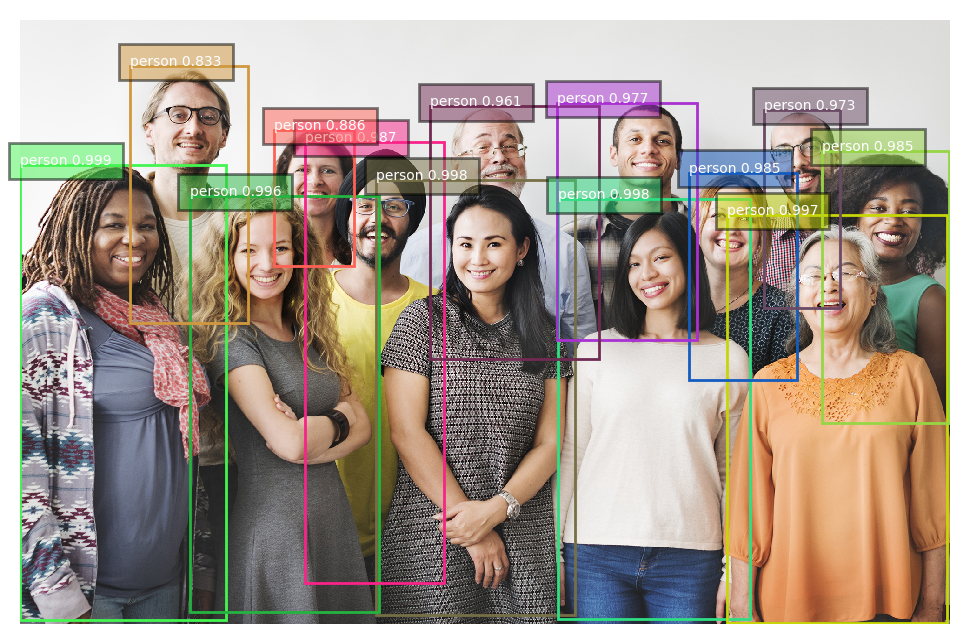

In [11]:
plt.rcParams['figure.dpi'] = 200
object_detection(model, './img/people.jpg', 0.8)

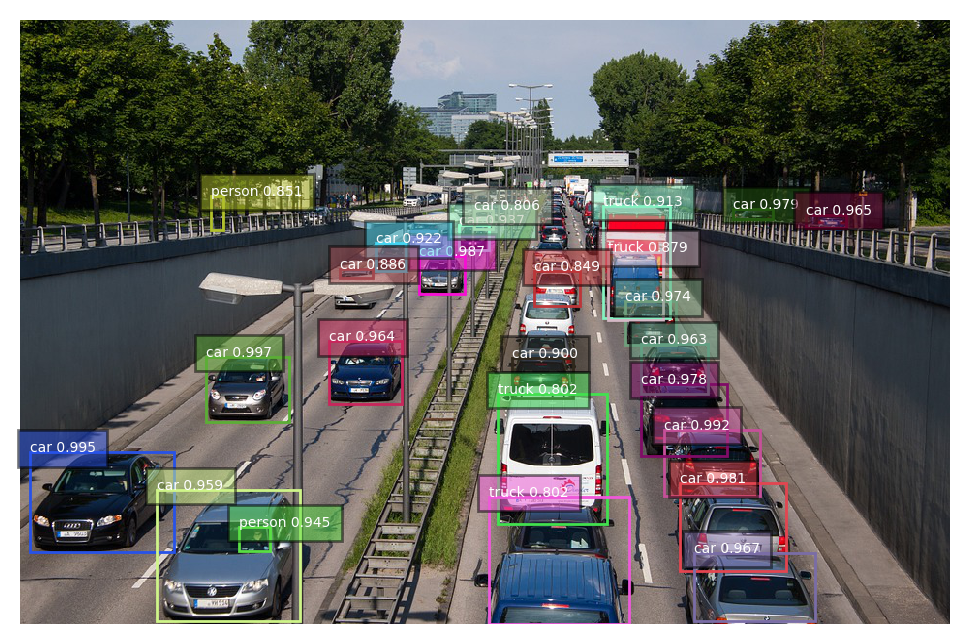

In [12]:
object_detection(model, './img/traffic.jpg', 0.8)